In [69]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as rp
import gmaps
from config import gkey
import scipy.stats as stats

In [3]:
base = "http://ufo-api.herokuapp.com/api/sightings/location/near?"
Ontario_lat_max = 56.800878
Ontario_lat_min = 41.771312
Ontario_lng_max = -75.251467
Ontario_lng_min = -95.281572

lats = np.random.uniform(low=-90, high=90, size=2000)
lngs = np.random.uniform(low=-90, high=90, size=2000)


In [4]:
len(lats), len(lngs)

(2000, 2000)

In [5]:
city = []
shape = []
state = []
date = []
duration = []
lats_ON = []
lngs_ON = []
for i in np.arange(0,len(lats)):
    try:
        responce = rp.get(f"{base}lat={lats[i]}&lon={lngs[i]}&limit=1").json()
#         if responce["sightings"][0]["obj"]["state"] == "ON":
        city.append(responce["sightings"][0]["obj"]["city"])
        shape.append(responce["sightings"][0]["obj"]["shape"])
        state.append(responce["sightings"][0]["obj"]["state"])
        date.append(responce["sightings"][0]["obj"]["date"])
        duration.append(responce["sightings"][0]["obj"]["duration"])
        lats_ON.append(responce["sightings"][0]["obj"]["loc"][1])
        lngs_ON.append(responce["sightings"][0]["obj"]["loc"][0])
    except Exception as e:
        print("could not find")
print("finished")

finished


In [6]:
Combined = pd.DataFrame({"lat":lats_ON,"lng":lngs_ON,"city":city,"shape":shape,"state":state,"date":date,"duration":duration})
cities_strength = Combined.groupby("city").count()
cities_strength = cities_strength.reset_index()
Combined = Combined.drop_duplicates("city")
cities_strength.set_index("city",inplace = True)
cities_strength = pd.DataFrame(cities_strength.loc[Combined["city"],"lat"])
cities_strength.reset_index(inplace = True)
cities_strength.rename(columns = {"lat":"strength"},inplace=True)
cities_strength["Normalised"] = (cities_strength["strength"]/cities_strength["strength"].sum())*100
Combined = pd.merge(Combined,cities_strength,on="city")
Combined.head()

,lat,lng,city,shape,state,date,duration,strength,Normalised
0,9.413042,-84.069955,Quepos (Costa Rica),Disk,,1982-06-01T16:00:00.000Z,1hr,4,0.20
1,-41.471851,-72.939613,Puerto Montt (Chile),Light,,2011-01-28T21:00:00.000Z,1 minute,13,0.65
2,2.889443,-73.783892,Columbia,Circle,,2014-01-23T11:00:00.000Z,,5,0.25
3,-34.481009,-54.336561,Rocha (Uruguay),Fireball,,2009-05-14T19:20:00.000Z,30 seconds,12,0.60
4,-42.882509,147.328123,Hobart,Light,IN,2016-05-20T21:00:00.000Z,15+ seconds,7,0.35


In [18]:
gkey = ""
gmaps.configure(api_key=gkey)
figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

In [35]:

coordinates = Combined[["lat","lng"]]
# coordinates
# markers = gmaps.marker_layer(coordinates)
# # Add the layer to the map
# fig.add_layer(markers)
# fig
# Combined[Combined["lat"]<=-50]

In [47]:

heat_layer = gmaps.heatmap_layer(coordinates, weights=Combined["strength"], 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1.0)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 1000
heat_layer.point_radius = 5

fig.add_layer(heat_layer)

fig


Figure(layout=FigureLayout(border='1px solid black', height='300px', margin='0 auto 0 auto', padding='1px', wi…

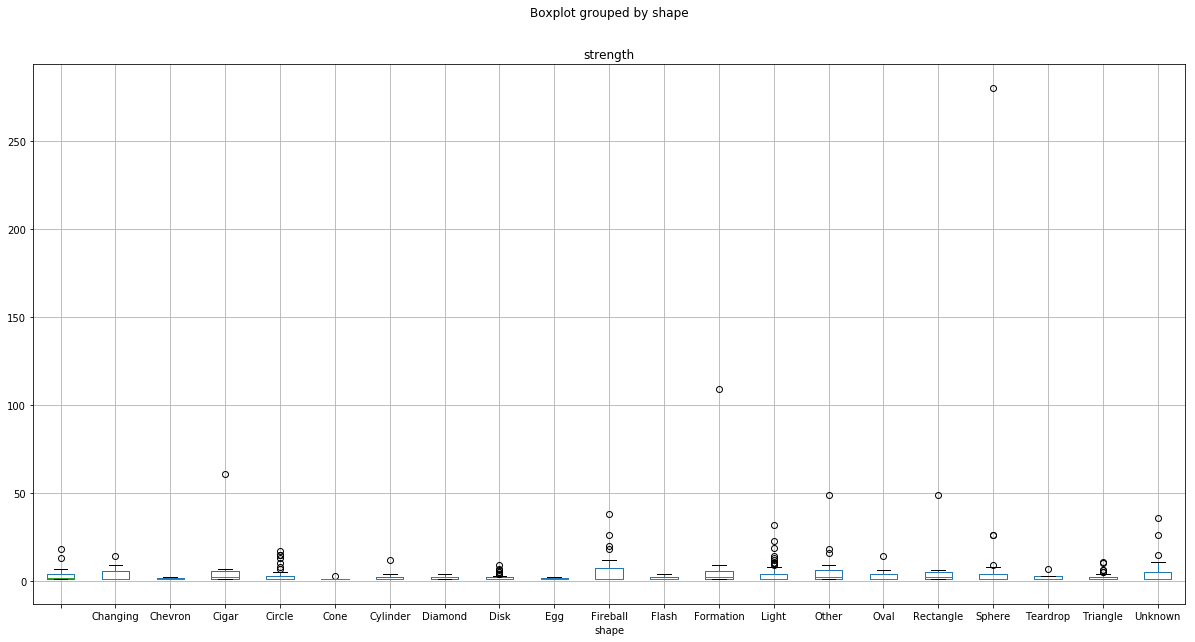

In [50]:
Combined.boxplot("strength", by="shape", figsize=(20, 10))

(array([0.42682927, 0.06097561, 0.0152439 , 0.0152439 , 0.0152439 ,
        0.0152439 , 0.        , 0.0152439 , 0.04573171, 0.0152439 ]),
 array([ 1. ,  2.6,  4.2,  5.8,  7.4,  9. , 10.6, 12.2, 13.8, 15.4, 17. ]),
 <a list of 10 Patch objects>)

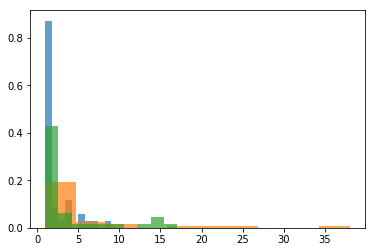

In [79]:
Combined[Combined["shape"]=="Disk"]["strength"]
plt.hist(Combined[Combined["shape"]=="Disk"]["strength"], 10, density=True, alpha=0.7, label="population1")
plt.hist(Combined[Combined["shape"]=="Fireball"]["strength"], 10, density=True, alpha=0.7, label="population1")
plt.hist(Combined[Combined["shape"]=="Circle"]["strength"], 10, density=True, alpha=0.7, label="population1")
# plt.hist(Combined[Combined["shape"]=="Egg"]["strength"], 10, density=True, alpha=0.7, label="population1")

In [78]:
stats.f_oneway(Combined[Combined["shape"]=="Disk"]["strength"],Combined[Combined["shape"]=="Fireball"]["strength"],Combined[Combined["shape"]=="Egg"]["strength"])

F_onewayResult(statistic=3.7673670630138885, pvalue=0.027662742470443095)